In [17]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation,Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import tqdm

In [2]:
K.clear_session() 

In [3]:
def process_for_vgg(file):
    #read the image into array
    #resize the array
    image = cv2.imread(file)
    #Interpolation is to not lose info on squishing
    image = cv2.resize(image, dsize=(224,224),interpolation=cv2.INTER_CUBIC)
    return image

In [4]:
#Import images Covid+
X = []
y = []
path = '/Users/iremn/PythonClass/Spiced/Personal_Projects/CoVid_Image/COVID-CT/Images-processed/CT_COVID/'
train_data = os.listdir(path)
for picture in tqdm.tqdm(train_data):
    image = process_for_vgg(path+picture)
    X.append(image)
    y.append(1)

100%|██████████| 349/349 [00:04<00:00, 79.27it/s]


In [5]:
#Import images Covid-
path = '/Users/iremn/PythonClass/Spiced/Personal_Projects/CoVid_Image/COVID-CT/Images-processed/CT_NonCOVID/'
train_data = os.listdir(path)
for picture in tqdm.tqdm(train_data):
    image = process_for_vgg(path+picture)
    X.append(image)
    y.append(0)

100%|██████████| 397/397 [00:03<00:00, 131.60it/s]


In [6]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#Convert all data to arrays
X_tr = np.array(X_train)
y_tr = np.array(y_train)
X_test_a = np.array(X_test)
y_test_a = np.array(y_test)


In [8]:
#Check shapes
X_tr.shape, y_tr.shape, X_test_a.shape, y_test_a.shape

((596, 224, 224, 3), (596,), (150, 224, 224, 3), (150,))

In [9]:
#Normalize X
X_tr = X_tr/255
X_test_a = X_test_a/255

In [10]:
#Categorize target data
y_tr = to_categorical(y_train)
y_test_a = to_categorical(y_test_a)

In [11]:
#Instantiate the model
K.clear_session() 

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
new_layers = base_model.output
new_layers = MaxPooling2D(pool_size = (4,4))(new_layers)
new_layers = Flatten()(new_layers)
new_layers = Dense(64, activation='relu')(new_layers)
new_layers = Dropout(0.5)(new_layers)
new_layers = Dense(2, activation='softmax')(new_layers)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
new_model = Model(inputs=base_model.inputs, outputs = new_layers)

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
#Compile the model 
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
covid_fit = new_model.fit(X_tr, y_tr, batch_size=10, epochs =10, validation_split = 0.3) #batch size for taking how many datapoint

Train on 417 samples, validate on 179 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
417/417 [==============================] - 433s 1s/sample - loss: 0.8572 - acc: 0.5156 - val_loss: 0.6226 - val_acc: 0.6704
Epoch 2/10
417/417 [==============================] - 370s 888ms/sample - loss: 0.6207 - acc: 0.6571 - val_loss: 0.5771 - val_acc: 0.7430
Epoch 3/10
417/417 [==============================] - 374s 897ms/sample - loss: 0.6359 - acc: 0.6379 - val_loss: 0.6861 - val_acc: 0.4804
Epoch 4/10
417/417 [==============================] - 374s 896ms/sample - loss: 0.5860 - acc: 0.6978 - val_loss: 0.5652 - val_acc: 0.7430
Epoch 5/10
417/417 [==============================] - 381s 914ms/sample - loss: 0.5434 - acc: 0.7098 - val_loss: 0.5562 - val_acc: 0.7486
Epoch 6/10
417/417 [==============================] - 367s 879ms/sample - loss: 0.5188 - acc: 0.7698 - val_loss: 0.5334 - val_acc: 0.7877
Epoch 7/10
417/417 [==============================] - 303s 727ms/sample - loss: 0

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


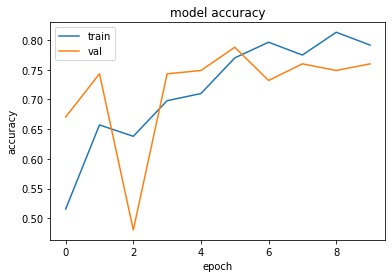

In [18]:
print(covid_fit.history.keys())
# summarize history for accuracy
plt.plot(covid_fit.history['acc'])
plt.plot(covid_fit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()


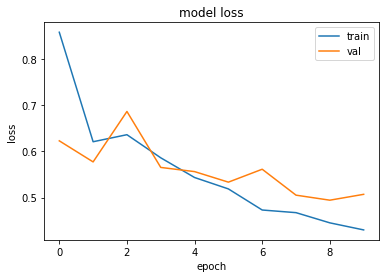

In [19]:
# summarize history for loss
plt.plot(covid_fit.history['loss'])
plt.plot(covid_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [20]:
pred = new_model.predict(X_tr, batch_size=10)

In [21]:
def final_plot(X_train, ytrue, ypred):
    for i in range(25):
        plt.subplot(5,5, i+1)
        plt.tight_layout()
        plt.axis('off')
        if (np.argmax(ypred[i])) == [ytrue[i]]:
            plt.imshow(X_train[i], alpha = 1.0)
        else:
            plt.imshow(X_train[i], alpha = 0)

        #plt.title(classes[argmax(ypred[i])])
        #plt.xlabel(classes[ytrue[i]])


In [42]:
def to_argmax(array):
    argm = []
    for i in range(len(array)):
        argm.append(np.argmax(array[i]))
    return argm

In [43]:
y_tr_pred = to_argmax(pred)

In [46]:
y_tr

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [49]:
#Recall score of train
recall_train = recall_score(y_train, y_tr_pred)
precision_train = precision_score(y_train, y_tr_pred)

In [50]:
print(precision_train, recall_train)

0.7713414634146342 0.9068100358422939


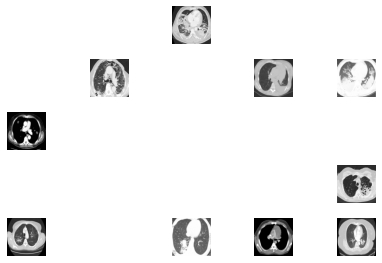

In [51]:
final_plot(X_train, y_train, y_tr_pred)

In [23]:
# Test data

test_loss, test_acc = new_model.evaluate(X_test_a, y_test_a)

print('Test accuracy:', test_acc)

150/150 [==============================] - 159s 1s/sample - loss: 0.5594 - acc: 0.7133
Test accuracy: 0.7133333


In [24]:
print('Test loss:', test_loss)

Test loss: 0.559394584496816


In [25]:
pred_test = new_model.predict(X_test_a, batch_size=10)

In [52]:
y_test_pred = to_argmax(pred_test)

In [54]:
#Recall score of train
recall_test = recall_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)

In [55]:
print(precision_test, recall_test)

0.6421052631578947 0.8714285714285714


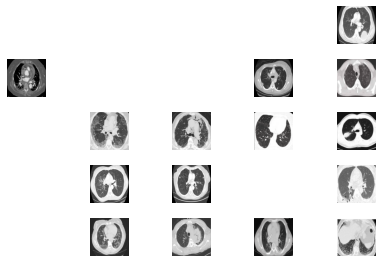

In [56]:
final_plot(X_test, y_test, y_test_pred)